In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3

In [2]:
text_df = pd.read_csv("output/troll_detection/authors_citations/ok/textblob.csv")
text_df = text_df.reindex(columns=['authid','text'])
text_df.head(3)

,authid,text
0,16309395600,Oil spill detection system - Results from fiel...
1,16310768700,Oil spill detection system - Results from fiel...
2,23024335400,Propagation of trust and distrust for the dete...


In [3]:
stopwords = nltk.corpus.stopwords.words('english')

In [4]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for row in text_df.itertuples():
    i=row[-1]
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 14127 items in vocab_frame


In [8]:
vocab_frame = vocab_frame.drop_duplicates()
vocab_frame.describe()
#vocab_frame.head(10)

,words
count,1258
unique,1258
top,obstacle
freq,1


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer( max_features=20000,max_df=0.95,
                                 min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                    ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['text']) #fit the vectorizer to synopses
print('tfidf_matrix has (rows(authors), cols(keywords)):')
print(tfidf_matrix.shape)

CPU times: user 427 ms, sys: 4.05 ms, total: 431 ms
Wall time: 435 ms
tfidf_matrix has (rows(authors), cols(keywords)):
(48, 632)


In [10]:
terms = tfidf_vectorizer.get_feature_names()
len(tfidf_vectorizer.get_feature_names())

632

In [11]:
' ,'.join(terms[:100])

"'s ,2014.the ,abil ,abstract ,access ,accident ,accompani ,account ,accur ,accuraci ,achiev ,acm.sign ,acoust ,act ,action ,activ ,actual ,adapt ,administr ,advantag ,aerial ,affect ,agenc ,aggreg ,ai ,aim ,al ,algorithm ,allow ,almost ,along ,also ,alter-ego ,amount ,analys ,analysi ,analyt ,analyz ,ani ,annular ,anomal ,anomali ,anonym ,antarctica ,apertur ,appeal ,appear ,appli ,applic ,approach ,approxim ,argument ,articl ,assist ,associ ,atmospher ,attack ,author ,autom ,automat ,avail ,awar ,b.v. ,back ,backpressur ,base ,baselin ,basi ,becaus ,becom ,befor ,behavior ,behaviour ,benefit ,benign ,bias ,binari ,boat ,bot ,bottom-hol ,bring ,bypass ,call ,capabl ,carri ,case ,categoris ,caus ,certifi ,challeng ,characterist ,choke ,christma ,circul ,classif ,classifi ,clean ,clear ,close ,cluster"

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
cosdist = 1 - cosine_similarity(tfidf_matrix)
np.round(cosdist,2)

array([[-0.  , -0.  ,  0.92, ...,  0.65,  0.92,  0.65],
       [-0.  , -0.  ,  0.92, ...,  0.65,  0.92,  0.65],
       [ 0.92,  0.92,  0.  , ...,  0.97,  0.  ,  0.97],
       ..., 
       [ 0.65,  0.65,  0.97, ...,  0.  ,  0.97,  0.  ],
       [ 0.92,  0.92,  0.  , ...,  0.97,  0.  ,  0.97],
       [ 0.65,  0.65,  0.97, ...,  0.  ,  0.97,  0.  ]])

In [13]:
from sklearn.mixture import GaussianMixture

num_clusters = 5

# Try GMMs using different types of covariances.
#estimators = dict((cov_type, GaussianMixture(n_components=n_clusters,
#                   covariance_type=cov_type, max_iter=20, random_state=0))
#                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

em = GaussianMixture(n_components=num_clusters,covariance_type='spherical', max_iter=20, random_state=0)
%time em.fit(tfidf_matrix.toarray())



CPU times: user 11.6 ms, sys: 4.35 ms, total: 16 ms
Wall time: 25.5 ms


GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=20, means_init=None, n_components=5, n_init=1,
        precisions_init=None, random_state=0, reg_covar=1e-06, tol=0.001,
        verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

In [14]:
clusters = em.predict(tfidf_matrix.toarray())
clusters

array([2, 2, 3, 3, 4, 4, 3, 1, 3, 3, 1, 4, 3, 3, 0, 3, 2, 3, 3, 3, 1, 0, 3,
       0, 2, 1, 4, 1, 0, 1, 4, 3, 4, 2, 3, 1, 4, 1, 4, 3, 1, 1, 3, 0, 0, 2,
       3, 2])

In [15]:
output = { 'authid': list(text_df['authid']), 'cluster': clusters, 'text': list(text_df['text']) }

frame = pd.DataFrame(output, index = [clusters] , columns = ['authid', 'cluster', 'text'])

In [29]:
print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = em.means_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster {} words:".format(i), end='')
    
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
        print(' {}'.format(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]), end=',')
    print() #add whitespace
    
    print("Cluster {} has ".format(i), end='')
    print('{} authors.'.format(len(frame.ix[i]['authid'].values.tolist())))
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: 'signed, slashdot, network, ranking, model, many, social, algorithm, zoo, tia,
Cluster 0 has 6 authors.

Cluster 1 words: sentiment, analysis, troll, discussion, media, bots, forums, binary, ordinal, fakeholders,
Cluster 1 has 10 authors.

Cluster 2 words: oil, satellite, services, vessels, spill, ksat, pollution, trials, operation, identification,
Cluster 2 has 7 authors.

Cluster 3 words: social, trust, users, network, real, generation, comment, profiles, news, methods,
Cluster 3 has 17 authors.

Cluster 4 words: gas, control, drilling, system, well, installation, riser, gradient, dual, tested,
Cluster 4 has 8 authors.



<h2>Clustering done. Visualization tips here...</h2>

We got a n_samples*n_features sparse matrix.

For high-dimensional sparse data it is helpful to <b>first reduce the dimensions to 50 dimensions with TruncatedSVD</b> and <b>then perform t-SNE</b>. 
This will usually improve the visualization.

In [42]:
#TruncatedSVD and t-SNE on cosdist matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

X_reduced = TruncatedSVD(n_components=20, random_state=0).fit_transform(cosdist)
X_cosdist = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 2.121431
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.842850
[t-SNE] Error after 100 iterations: 0.842850


In [43]:
#TruncatedSVD and t-SNE on tfidf_matrix

X_reduced = TruncatedSVD(n_components=20, random_state=0).fit_transform(tfidf_matrix)
X_tfidf = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 1.012254
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.929991
[t-SNE] Error after 125 iterations: 0.929991


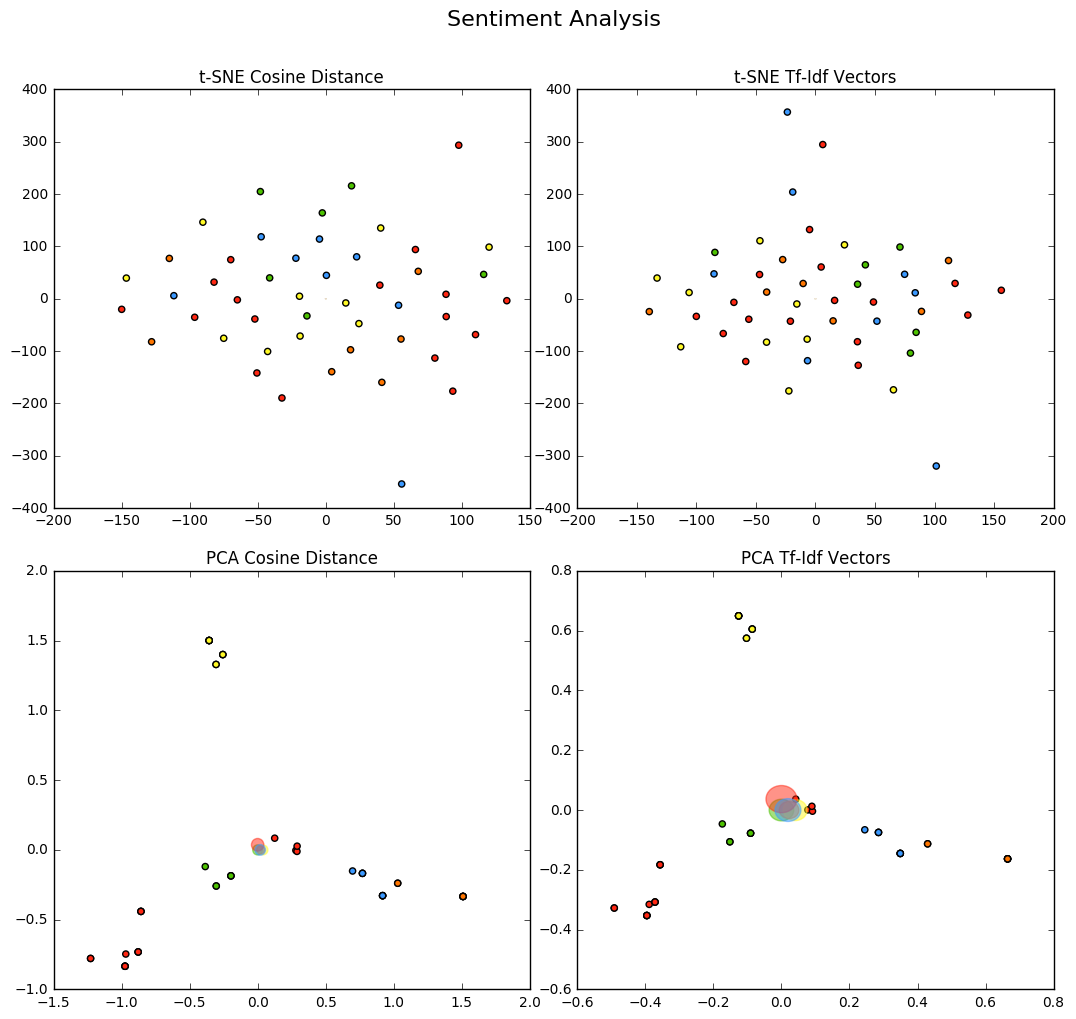

In [44]:
from sklearn.decomposition import PCA
import matplotlib.patches as patches
import matplotlib.pyplot as plt

pca_tfidf = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())
pca_cosdist = PCA(n_components=2).fit_transform(cosdist)

%matplotlib inline 

colormap = np.array(['#4DC200', '#FFF926', '#FF7600', '#FF2813', '#3B99FF'])

#2d plot

def make_ellipses(gmm, ax):
    for n, color in enumerate(colormap):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

fig = plt.figure(figsize=(10, 10))
# plot setup
fig.suptitle("Sentiment Analysis", fontsize=16)
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.1, hspace=0.15)
# 1st plot
ax = plt.subplot("221")
ax.set_title("t-SNE Cosine Distance")
ax.scatter(X_cosdist[:, 0], X_cosdist[:, 1],
        c=colormap[clusters], marker="o")
make_ellipses(em, ax)

# 2nd plot
ax = plt.subplot("222")
ax.set_title("t-SNE Tf-Idf Vectors")

ax.scatter(X_tfidf[:, 0], X_tfidf[:, 1],
        c=colormap[clusters], marker="o")
make_ellipses(em, ax)
# 3rd plot
ax = plt.subplot("223")
ax.set_title("PCA Cosine Distance")

ax.scatter(pca_cosdist[:,0], pca_cosdist[:,1], c=colormap[clusters])
make_ellipses(em, ax)
# 4th plot
ax = plt.subplot("224")
ax.set_title("PCA Tf-Idf Vectors")

ax.scatter(pca_tfidf[:,0], pca_tfidf[:,1], c=colormap[clusters], marker="o")
make_ellipses(em, ax)

# convert this to a code cell to create and print 3D plots
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(cosdist)
tsne_3d_cosdist = TSNE(n_components=3, perplexity=40, verbose=1).fit_transform(X_reduced)

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)
tsne_3d_tfidf = TSNE(n_components=3, perplexity=40, verbose=1).fit_transform(X_reduced)

pca_3d_tfidf = PCA(n_components=3).fit_transform(tfidf_matrix.toarray())
pca_3d_cosdist = PCA(n_components=3).fit_transform(cosdist)

fig = plt.figure(figsize=(10, 10))

fig.suptitle("Sentiment Analysis", fontsize=16)
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.1, hspace=0.15)


ax = plt.subplot("221",projection='3d')
ax.set_title("t-SNE Cosine Distance")
ax.scatter(tsne_3d_cosdist[:, 0], tsne_3d_cosdist[:, 1], tsne_3d_cosdist[:, 2],
        c=colormap[km.labels_], marker="o")

ax = plt.subplot("222",projection='3d')
ax.set_title("t-SNE Tf-Idf Vectors")
ax.scatter(tsne_3d_tfidf[:, 0], tsne_3d_tfidf[:, 1], tsne_3d_tfidf[:, 2],
        c=colormap[km.labels_], marker="o")

ax = plt.subplot("223",projection='3d')
ax.set_title("PCA Cosine Distance")
ax.scatter(pca_3d_cosdist[:, 0], pca_3d_cosdist[:, 1], pca_3d_cosdist[:, 2],
        c=colormap[km.labels_], marker="o")


ax = plt.subplot("224",projection='3d')
ax.set_title("PCA Tf-Idf Vectors")
ax.scatter(pca_3d_tfidf[:, 0], pca_3d_tfidf[:, 1], pca_3d_tfidf[:, 2],
        c=colormap[km.labels_], marker="o")

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(cosdist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=text_df['authid']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters